# Pedro - Short Queeze Predictor
---

### 1. Libraries Import

In [117]:
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

import tensorflow as tf
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder

### 2. Data Import

In [118]:
merged_df = pd.read_csv(
    Path("Resources/ShortSqueezeData.csv"),
    parse_dates=True,
    infer_datetime_format=True
)

### 3. Data Cleaning

In [119]:
columns_to_drop = ['Company Name', 'Close Price Day 1', 'Close Price Day 2', 'Close Price Day 5', 'Close Price Day 7',
                   'Close Price Day 15', 'Close Price Day 30', 'Return (1 Days)', 'Return (2 Days)',
                   'Return (5 Days)', 'Return (7 Days)', 'Return (15 Days)', 'Return (30 Days)',
                   'Highest Day Return', 'Highest Close Price']

merged_df = merged_df.drop(columns=columns_to_drop)

In [120]:
merged_df.drop_duplicates(subset=['Symbol', 'Short % of Float'], keep='first', inplace=True)

In [121]:
merged_df.head()

,Date,Symbol,Short % of Float,Total Amount,Market Cap,% Insider Ownership,Relation,Sector,Short Squeeze
0,2022-02-09,ASAN,26.61,3.498911e+06,4.969085e+09,23.30,"Large Shareholder, Officer, Director",Technology,1
6,2022-09-07,ASAN,17.92,3.500000e+08,2.637014e+09,30.69,"Large Shareholder, Officer, Director",Technology,1
9,2021-11-12,ATUS,20.71,1.001230e+06,4.739197e+09,13.47,Director,Communication Services,0
10,2021-09-27,AXDX,22.47,7.995000e+05,3.387720e+08,45.14,"Large Shareholder, Director",Healthcare,1
11,2021-11-18,AXDX,20.41,6.055088e+05,3.351096e+08,45.14,"Large Shareholder, Director",Healthcare,0


In [122]:
# Short Squeeze vs. Non Short Squeeze Counts in DataFrame
short_squeeze_count = merged_df.loc[merged_df['Short Squeeze'] == 1, 'Short Squeeze'].count()
no_short_squeeze_count = merged_df.loc[merged_df['Short Squeeze'] == 0, 'Short Squeeze'].count()

print("Short Squeeze:", short_squeeze_count)
print("Non Short Squeeze:", no_short_squeeze_count)

Short Squeeze: 20
Non Short Squeeze: 30


### 4. Data Visualization

<Figure size 1000x600 with 0 Axes>

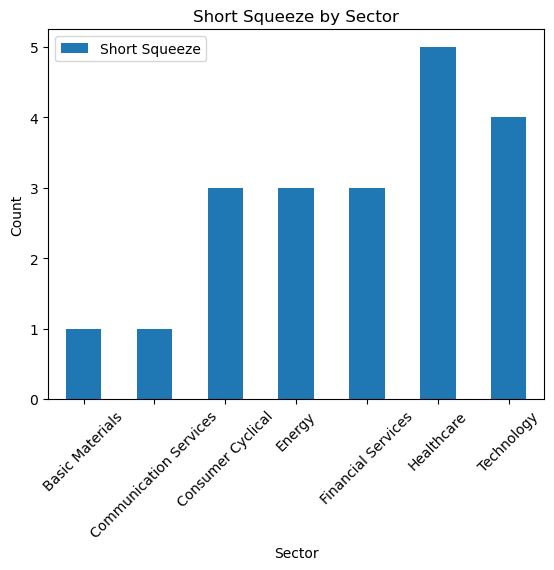

In [123]:
# Visualization by Sector
plt.figure(figsize=(10, 6))
grouped_df = merged_df.groupby('Sector')['Short Squeeze'].sum().reset_index()
grouped_df.plot(x='Sector', y='Short Squeeze', kind='bar')
plt.title('Short Squeeze by Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Figure size 800x600 with 0 Axes>

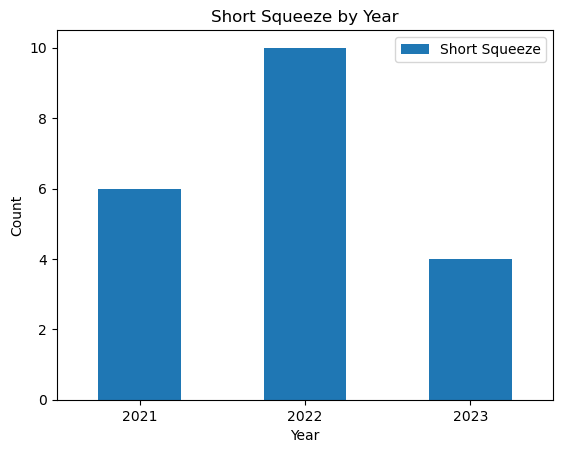

In [124]:
# Visualization by Year
merged_df['Year'] = pd.to_datetime(merged_df['Date']).dt.year
plt.figure(figsize=(8, 6))
grouped_df = merged_df.groupby('Year')['Short Squeeze'].sum().reset_index()
grouped_df.plot(x='Year', y='Short Squeeze', kind='bar')
plt.title('Short Squeeze by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### 5. One Hot Encoding

In [125]:
def one_hot_encode(df):
    encoder = OneHotEncoder(sparse=False)
    categorical_variables = ['Sector', 'Relation']
    encoded_data = encoder.fit_transform(df[categorical_variables])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_variables))
    encoded_df.index = df.index 
    numerical_df = df.drop(columns=categorical_variables, axis=1)
    return pd.concat([numerical_df, encoded_df], axis=1)

In [126]:
# One hot encode the data
merged_df = one_hot_encode(merged_df)

### 6. Train-Test Split

In [127]:
# Drop the 'Short Squeeze', 'Symbol' and 'Date' columns for features
X = merged_df.drop(columns=['Short Squeeze', 'Symbol', 'Date'])
y = merged_df['Short Squeeze']

# split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 8. Data Normalization

In [128]:
# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 9. Model Training

#### Gradient Boosting Classifier

In [129]:
# Create the classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

In [130]:
# Train the model
gb_classifier.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=42)

In [131]:
# Predict the test data
y_pred_gb = gb_classifier.predict(X_test_scaled)

In [132]:
# Print classification report
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.50      0.33      0.40         3

    accuracy                           0.70        10
   macro avg       0.62      0.60      0.60        10
weighted avg       0.68      0.70      0.68        10



#### Support Vector Machine (SVM)

In [133]:
# Create the classifier
svc_classifier = SVC(random_state=42)

In [134]:
# Train the model
svc_classifier.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [135]:
# Predict the test data
y_pred_svc = svc_classifier.predict(X_test_scaled)

In [136]:
# Print classification report
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.00      0.00      0.00         3

    accuracy                           0.50        10
   macro avg       0.31      0.36      0.33        10
weighted avg       0.44      0.50      0.47        10

